## **1. Получение уникальных пользователей и их данных**

In [1]:
import requests
import datetime
import time
import json
import random
import pandas as pd

USER_ID = 'SamplingAcc' # тестовый аккаунт №1
USER_ID_2 = 'SamplingAcc1' # тестовый аккаунт №2
MAX_GAMES = 60  # Максимальное количество игр для извлечения за раз
API_HEADERS = {'Accept': 'application/x-ndjson'}

# время создания тестового аккаунта в милисекундах и время месяц назад от этого события
Creation_time = requests.get('https://lichess.org/api/user/{}'.format(USER_ID)).json().get('createdAt')
time_delta_30_days = datetime.timedelta(days=30).total_seconds() * 1000
one_month_ago = int(Creation_time - time_delta_30_days)

# Функция для парсинга игр и извлечения оппонентов
def get_opponents_from_games(games):
    opponents = set() # Используем множество для избежания дубликатов
    for game in games:
        game_data = json.loads(game)
        try:
            opponents.add(game_data['players']['black']['user']['id'])
            opponents.add(game_data['players']['white']['user']['id'])
        except:
            continue
    return list(opponents)

# Функция для получения списка игр пользователя за последний месяц
def get_games_last_month(username, max_games):
 
    url = 'https://lichess.org/api/games/user/{}'.format(username)
    params = {
        'max': max_games,
        'since': one_month_ago,
        'opening': 'false',
        'pgnInJson': 'false'
    }

    response = requests.get(url, params=params, headers=API_HEADERS)
    
    if response.status_code == 200:
        games = response.text.strip().split('\n')
        return games
    else:
        return []

# Функция для получения первоночальных оппонентов (для тестового аккаунта)
def get_initial_opponents(user_id):
    games = get_games_last_month(user_id, 50)
    opponents = get_opponents_from_games(games)
    return opponents

# Функция для получения датафрейма со всей необходимой информацией об игроках
def get_player_data_for_users(user_ids):
    url = 'https://lichess.org/api/users'
    headers = {'Content-Type': 'text/plain'}
    
    data = ','.join(user_ids)  # Список пользователей через запятую
    response = requests.post(url, headers=headers, data=data)
    
    if response.status_code == 200:
        users_data = response.json()
        players_info = []
        
        for user in users_data:
            profile = user.get('profile', {})
            blitz = user.get('perfs', {}).get('blitz', {})
            rapid = user.get('perfs', {}).get('rapid', {})
            bullet = user.get('perfs', {}).get('bullet', {})
            puzzle = user.get('perfs', {}).get('puzzle', {})
            racer = user.get('perfs', {}).get('racer', {})
            classical = user.get('perfs', {}).get('classical', {})
            play_time = user.get('playTime', {})
            
            player_info = {
                'username': user.get('username'),
                'createdAt': user.get('createdAt'),
                'play_time_total': play_time.get('total', None),
                'play_time_tv': play_time.get('tv', None),
                'flag': profile.get('flag', None),
                'blitz_rating': blitz.get('rating', None),
                'blitz_rd': blitz.get('rd', None),
                'blitz_games': blitz.get('games', None),
                'blitz_prog': blitz.get('prog', None),
                'rapid_rating': rapid.get('rating', None),
                'rapid_rd': rapid.get('rd', None),
                'rapid_games': rapid.get('games', None),
                'bullet_rating': bullet.get('rating', None),
                'bullet_rd': bullet.get('rd', None),
                'bullet_games': bullet.get('games', None),
                'classical_rating': classical.get('rating', None),
                'classical_rd': classical.get('rd', None),
                'classical_games': classical.get('games', None),
                'puzzle_rating': puzzle.get('rating', None),
                'puzzle_rd': puzzle.get('rd', None),
                'puzzle_games': puzzle.get('games', None),
                'racer_runs': racer.get('runs', None),
                'racer_score': racer.get('score', None)              
            }
            players_info.append(player_info)
        
        return pd.DataFrame(players_info)
    else:
        print("Error getting data:", response.status_code)
        return pd.DataFrame()  

# Функция для получения всех оппонентов по цепочке от начальных оппонентов, итерируем 2 раза
def get_all_opponents(initial_opponents):
    opponents = initial_opponents
    all_opponents = []
    
    for i in range (2):
        for user in opponents:
            games = get_games_last_month(user, MAX_GAMES)
            opps = get_opponents_from_games(games)
            all_opponents.extend(opps)
        opponents = set(all_opponents)
    all_opponents = list(set(all_opponents))
    return(all_opponents)   

**Получаем список начальных оппонентов по двум тестовым аккаунтам, в которых оппоненты охватывают большой диапазон рейтингов, примерно от 700 до 2400. Далее получаем оппонентов их оппонентов, и так 2 раза. Максимальное количество получаемых оппонентов одного игрока установлено в параметре MAX_GAMES = 60.**

In [2]:
initial_opponents = get_initial_opponents(USER_ID)
initial_opponents.extend(get_initial_opponents(USER_ID_2))
all_opponents = get_all_opponents(initial_opponents)

In [3]:
len(initial_opponents)  # количество начальных оппонентов

68

In [4]:
len(all_opponents)  # полученное количество уникальных оппонентов

114477

**Получаем информацию по всем полученным уникальным игрокам и записываем в DataFrame.
"Get users by ID Get up to 300 users by their IDs.
This endpoint is limited to 8,000 users every 10 minutes, and 120,000 every day."**

In [5]:
all_players_info = pd.DataFrame()  
queue = all_opponents
    
while len(all_players_info) < len(all_opponents) * 0.95:
        # Берем пользователей из очереди и запрашиваем их инфо массово
        current_batch = queue[:300]  # Отправляем запросы по 300 пользователей
        queue = queue[300:]
        players_info = get_player_data_for_users(current_batch)
        
        if players_info.empty:  
            print("The request limit has been reached.. Waiting time 10 minutes...")
            time.sleep(10 * 60 + 1)  # Ждем 10 минут 
            continue  
        
        all_players_info = pd.concat([all_players_info, players_info]) 
        
print ('\nCollected info of {} players'.format(len(all_players_info)))

('Error getting data:', 429)
The request limit has been reached.. Waiting time 10 minutes...
('Error getting data:', 429)
The request limit has been reached.. Waiting time 10 minutes...
('Error getting data:', 429)
The request limit has been reached.. Waiting time 10 minutes...
('Error getting data:', 429)
The request limit has been reached.. Waiting time 10 minutes...
('Error getting data:', 429)
The request limit has been reached.. Waiting time 10 minutes...
('Error getting data:', 429)
The request limit has been reached.. Waiting time 10 minutes...
('Error getting data:', 429)
The request limit has been reached.. Waiting time 10 minutes...
('Error getting data:', 429)
The request limit has been reached.. Waiting time 10 minutes...
('Error getting data:', 429)
The request limit has been reached.. Waiting time 10 minutes...
('Error getting data:', 429)
The request limit has been reached.. Waiting time 10 minutes...
('Error getting data:', 429)
The request limit has been reached.. Wait

In [7]:
# Поскольку выборка, на распределение которой мы ориентируемся, относится к типу blitz, 
# отфильтруем пользователей, у которых хотя бы 1 игра в blitz.

blitz_players_info = all_players_info[all_players_info['blitz_games'] > 1].copy()

blitz_players_info.shape[0]

105592

In [8]:
blitz_players_info.head()

,blitz_games,blitz_prog,blitz_rating,blitz_rd,bullet_games,bullet_rating,bullet_rd,classical_games,classical_rating,classical_rd,...,play_time_tv,puzzle_games,puzzle_rating,puzzle_rd,racer_runs,racer_score,rapid_games,rapid_rating,rapid_rd,username
0,4169.0,28.0,1799.0,45.0,3.0,1320.0,303.0,4.0,1855.0,295.0,...,0.0,39153.0,1837.0,74.0,NaN,NaN,811.0,1948.0,45.0,Arminsaei
1,10819.0,20.0,1565.0,45.0,515.0,1511.0,45.0,3.0,1285.0,289.0,...,0.0,22.0,1146.0,226.0,NaN,NaN,32.0,1457.0,216.0,hparaph
2,10566.0,6.0,1891.0,45.0,7984.0,1758.0,57.0,1.0,1833.0,457.0,...,2937.0,154.0,1956.0,129.0,NaN,NaN,334.0,1961.0,166.0,Pawnov
3,4441.0,26.0,1674.0,45.0,935.0,1630.0,45.0,0.0,1500.0,500.0,...,0.0,2229.0,1666.0,75.0,NaN,NaN,5.0,1611.0,211.0,areconster
4,15.0,7.0,1729.0,173.0,0.0,1500.0,500.0,0.0,1500.0,500.0,...,0.0,88.0,2186.0,93.0,NaN,NaN,172.0,1868.0,45.0,J_King18


In [9]:
all_players_info.to_csv('all_players_info.csv', index=False)

## **2. Сэмплирование, получение репрезантативной выборки**

In [10]:
TARGET_SAMPLE_SIZE = 34000   # Целевой размер выборки

# Определение рейтинговых бинов и их целевых пропорций в соответствии с распределением lichess
RATING_BINS = {
    'below_800': {'min': 0, 'max': 800, 'target_pct': 0.03, 'current': 0},
    '800_1000': {'min': 800, 'max': 1000, 'target_pct': 0.08, 'current': 0},
    '1000_1200': {'min': 1000, 'max': 1200, 'target_pct': 0.14, 'current': 0},
    '1200_1300': {'min': 1200, 'max': 1300, 'target_pct': 0.08, 'current': 0},
    '1300_1400': {'min': 1300, 'max': 1400, 'target_pct': 0.085, 'current': 0},
    '1400_1500': {'min': 1400, 'max': 1500, 'target_pct': 0.09, 'current': 0},
    '1500_1600': {'min': 1500, 'max': 1600, 'target_pct': 0.09, 'current': 0},
    '1600_1700': {'min': 1600, 'max': 1700, 'target_pct': 0.09, 'current': 0},
    '1700_1800': {'min': 1700, 'max': 1800, 'target_pct': 0.08, 'current': 0},
    '1800_1900': {'min': 1800, 'max': 1900, 'target_pct': 0.07, 'current': 0},
    '1900_2000': {'min': 1900, 'max': 2000, 'target_pct': 0.06, 'current': 0},
    '2000_2100': {'min': 2000, 'max': 2100, 'target_pct': 0.04, 'current': 0},
    '2100_2325': {'min': 2100, 'max': 2325, 'target_pct': 0.05, 'current': 0},
    'above_2325': {'min': 2325, 'max': 3000, 'target_pct': 0.015, 'current': 0}
}

# Функция для определения бина по рейтингу
def get_rating_bin(rating):
    for bin_name, bin_info in RATING_BINS.items():
        if bin_info['min'] <= rating < bin_info['max']:
            return bin_name
    return None

# Функция для случайного выбора пользователей по бинам
def select_sample(df, final_sample_size):
    sample = pd.DataFrame()  # DataFrame для выборки

    # Определение целевого количества пользователей для каждого бина
    for bin_name, bin_info in RATING_BINS.items():
        bin_info['target_count'] = int(final_sample_size * bin_info['target_pct'])

    # Добавляем колонку с биноми в DataFrame
    df['bin'] = df['blitz_rating'].apply(get_rating_bin)

    # Для каждого бина случайно выбираем пользователей в соответствии с целевым размером
    for bin_name, bin_info in RATING_BINS.items():
        target_count = bin_info['target_count']
        
        # Фильтруем пользователей по текущему бину
        users_in_bin = df[df['bin'] == bin_name]
        
        if len(users_in_bin) < target_count:
            print("Not enought users in bin {}: {} availible, {} necessary.").format(bin_name, len(users_in_bin), target_count)
        
        # Выбираем случайных пользователей из данного бина
        selected_users = users_in_bin.sample(n=min(target_count, len(users_in_bin)))
        
        # Добавляем выбранных пользователей в итоговую выборку
        sample = pd.concat([sample, selected_users])

    return sample

In [11]:
sample_df = select_sample(blitz_players_info, TARGET_SAMPLE_SIZE)

In [12]:
sample_df.to_csv('sample_df.csv', index=False)

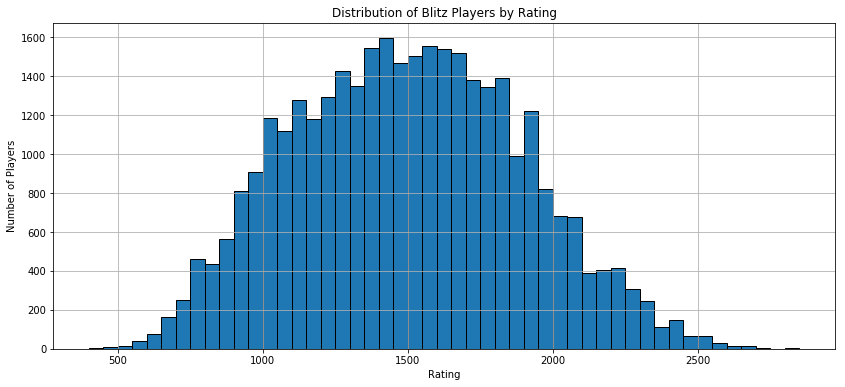

In [15]:
import matplotlib.pyplot as plt
ratings = sample_df['blitz_rating'].dropna()

# Построение гистограммы распределения игроков по рейтингам
plt.figure(figsize=(14,6))
plt.hist(ratings, bins=range(int(min(ratings)), int(max(ratings)) + 50, 50), edgecolor='black')
plt.title('Distribution of Blitz Players by Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Players')
plt.grid(True)
plt.show()

**Распределение полученной выборки близко к недельному распределению на сайте и приближенно отражает распределение
игроков по силе игры. Определение рейтинговых бинов и их целевых пропорций составлялось в сентябре 2024.
https://lichess.org/stat/rating/distribution/blitz**